In [9]:
import numpy as np
import skimage
import pandas as pd
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
import utils
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Detecção de bordas

Imagem original [1]


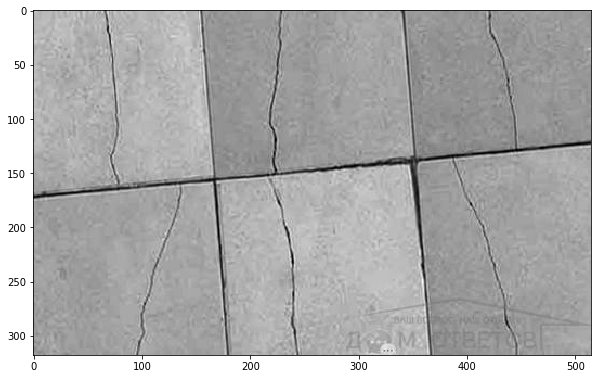

Alto contraste [1.1]


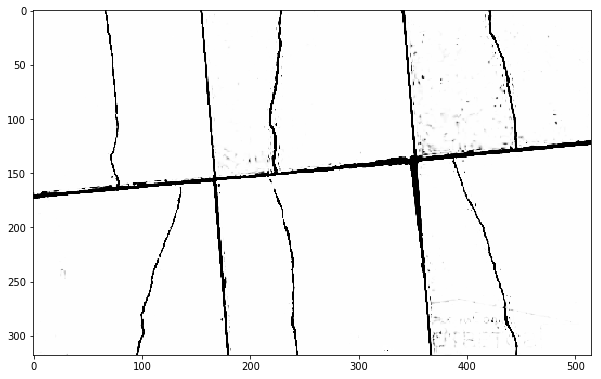

NameError: name 'filters' is not defined

In [10]:
img = utils.load_image(30)
print('Imagem original [1]')
plt.imshow(img)
plt.show()
pimg = img
pimg = skimage.exposure.adjust_sigmoid(pimg, gain=100)
print("Alto contraste [1.1]")
plt.imshow(pimg)
plt.show()
#pimg = filters.sobel(pimg)
thr = filters.thresholding.threshold_otsu(pimg)
pimg = pimg>thr
print("Otsu [1.2]")
plt.imshow(pimg)
plt.show()
num_white = np.sum(pimg)
num_black = np.prod(pimg.shape) - num_white
if num_white > num_black:
    pimg = 1 - pimg
    print("Inversão para que as rachaduras sejam brancas e o fundo preto [1.3]")
    plt.imshow(pimg)
    plt.show()
print("Esqueletização [1.4]")
pimg = morphology.skeletonize(pimg)
plt.imshow(pimg)

# Transformada de Hough
Os rejuntes diferem das rachaduras pelo fato de serem linhas retas, logo uma forma de distingui-los é utilizando a transformada de Hough para detectar retas

27 linhas detectadas


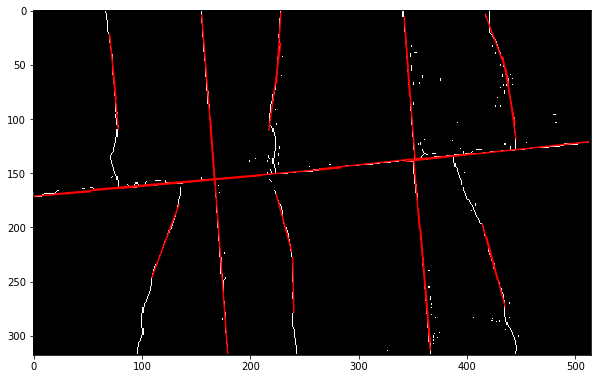

In [ ]:
lines = transform.probabilistic_hough_line(pimg)
print('{} linhas detectadas'.format(len(lines)))
plt.imshow(pimg)
for line in lines:
        plt.plot(*zip(*line), c='r')

# Identificando os rejuntes a partir das linhas detectadas
Embora as rachaduras sejam linhas irregulares elas possuem alguns segmentos retos que são detectados pela transformada de Hough. Entretando o maior numero de retas detectado se encontra nos rejuntes de modo que é possível extrair os rejuntes a partir de um histograma de direções. 

<BarContainer object of 180 artists>

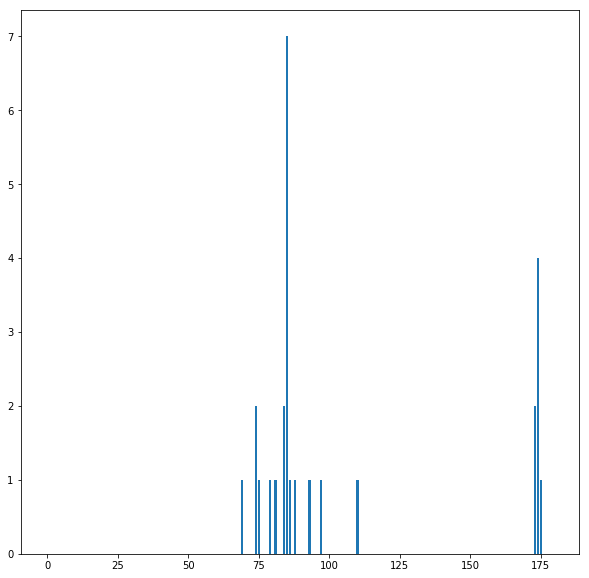

In [ ]:
directions = np.rad2deg(np.arctan([(y2-y1)/(x2-x1) for (x1,y1), (x2,y2) in lines]))
directions = np.where(directions < 0, directions + 180, directions)
hist = np.histogram(directions, range=[0,180], bins=180)
sort_indexes = np.argsort(hist[0])
hist = hist[0][sort_indexes], hist[1][sort_indexes]
plt.bar(hist[1], hist[0])

No histograma acima é possivel identificar duas direções dominantes que correspondem as direções dos rejuntes

In [ ]:
a1, a2 = hist[1][-2:]
print(a1, a2)

174.0 85.0


# Removendo rejuntes - otimizando frequência e fase
Uma forma de remover os rejuntes sem perder apagar as rachaduras é gerar uma grade com a frequencia e fase dos rejuntes, inverter e multiplicar pela imagem esqueletizada (1.4)

Exemplo de grade com frequência e fase especificada


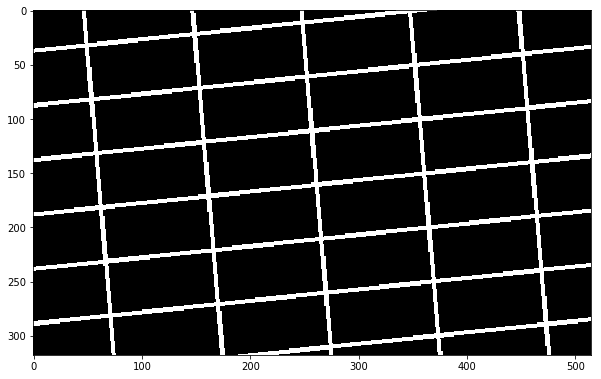

In [ ]:
print('Exemplo de grade com frequência e fase especificada')
plt.imshow(utils.grid(pimg.shape, [a1,a2], [0.02, 0.01], [1,3], 3))
plt.show()

# Encontrando a frequência e fase do rejunte
Pode-se aplicar um algoritmo de otimização para maximizar a seguinte função:
> $f(\vec{x}) = \frac{1}{H \cdot W}\sum {[G(\vec{x},esp) \cdot Im_{fit}]}$

onde:<br>
 - $\vec{x}$ é o vetor contendo as frequências e fases da grade;
 - $esp$ é a espessura da grade;
 - $G(\vec{x},esp)$ é a grade;
 - $Im_{fit}$ é a imagem esqueletizada com 0's trocados por $\frac{-1}{esp}$ e 1's por $esp$


In [1]:
width = 5
img_fit = np.where(pimg == 1, width, -1/width)

def auxGrid(freq1, phase1, freq2, phase2):
    return utils.grid(img_fit.shape, [a1,a2], [freq1, freq2], [phase1, phase2], width)

def denormalize(x):
    min_freq = 0.0016521614890856475
    high = np.array([0.5, 500, 0.5, 500])
    low = np.array([min_freq, 0, min_freq, 0])
    return (high-low)*np.abs(x) + low
  
def fitness(x):
    x = denormalize(x)
    freq1, phase1, freq2, phase2 = x
    grid_img = auxGrid(freq1, phase1, freq2, phase2)
    return np.mean(img_fit*grid_img)

NameError: ignored

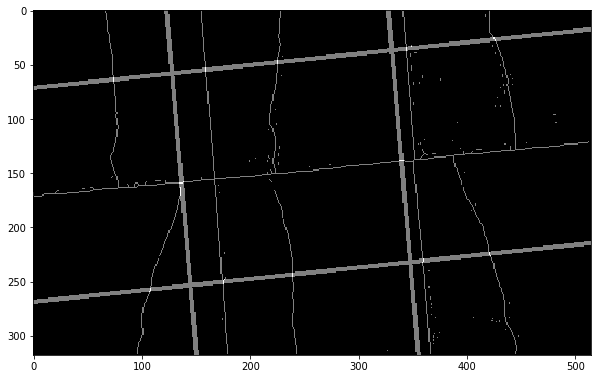

In [ ]:
freq1, phase1, freq2, phase2 = 0.005076465058218435, 173.01246882793018, 0.004892084622274588, 191.37292817679557
grid = utils.grid(pimg.shape, [a1,a2], [freq1, freq2], [phase1,phase2], 3)
plt.imshow(grid+pimg)

In [ ]:
from optimization.fss import FSS

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
import utils
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

99 (-0.27635708615741583, array([0.34141728, 0.20318346, 0.39038078, 0.83476806]))


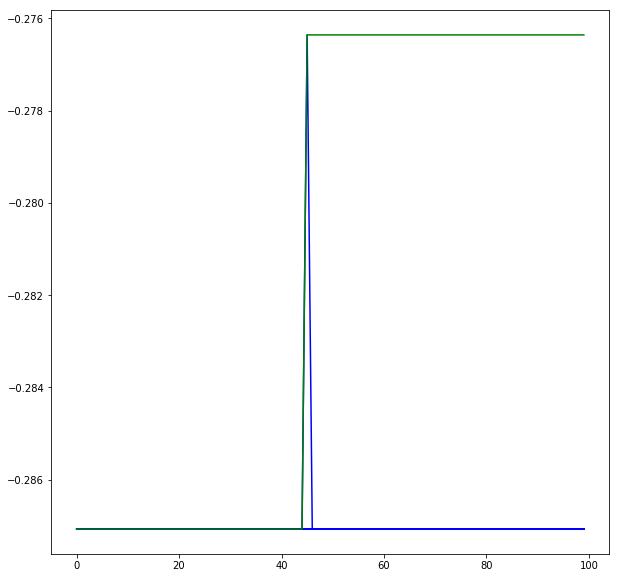

In [ ]:
optimizer = FSS(10, 0.1, 0.01)
aquarium = [[0, 1], [0, 1], [0, 1], [0, 1]]
optimizer.initSwarm(20, aquarium, 100)
fitness_values = []
best_fitness = []
for i in range(optimizer.iterations):
    optimizer.step(fitness)
    '''
    print('================ ' + str(i) + ' ================')
    print(optimizer.best)
    df = pd.DataFrame(index=['Weights', 'fitness'], data=np.concatenate([optimizer.W[None, ...], optimizer.fitness[None, ...]], axis=0))
    #display(df)
    #print(df)
    '''
    clear_output()
    print(i, optimizer.best)
    fitness_values.append(optimizer.fitness)
    best_fitness.append(optimizer.best[0])
for fv in np.array(fitness_values).T:
    plt.plot(fv, color='b')
plt.plot(best_fitness, color='g')

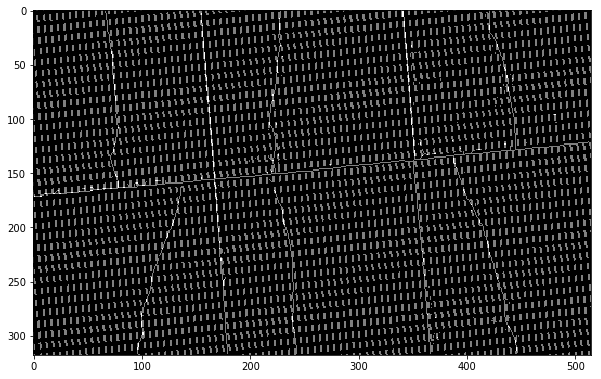

In [ ]:
bestGrid = auxGrid(*denormalize(optimizer.best[1]))
plt.imshow(pimg+(1-bestGrid))

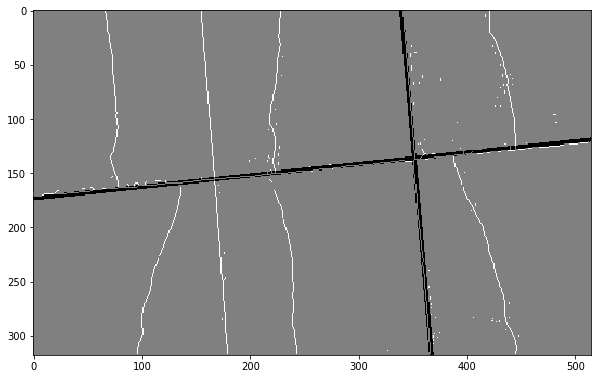

In [ ]:
import scipy
result = scipy.optimize.differential_evolution(lambda x : -fitness(x), bounds=aquarium)
aaa = auxGrid(*denormalize(result.x))
plt.imshow(pimg+(1-aaa))

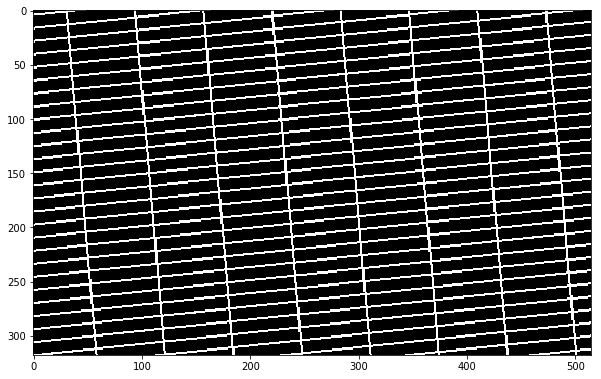

In [ ]:
plt.imshow(utils.grid(img_fit.shape, [a1,a2], [freq1, freq2], [phase1, phase2], width))

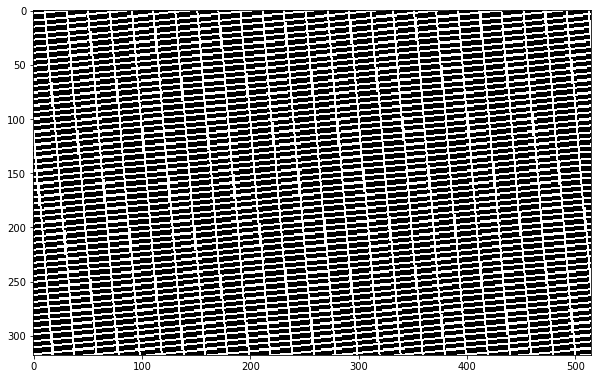

In [ ]:
plt.imshow(auxGrid(*denormalize(optimizer.best[1])))

In [ ]:
from optimization.pso import PSO

In [ ]:
swarm_size = 20
population = np.random.randn(swarm_size, 4)*.5
pso = PSO(population, 1, 1, 0.8)

In [ ]:
for i in range(1000):
    pso.minimize(lambda x : -fitness(x))
aaa = auxGrid(*denormalize(pso.gbest))
plt.imshow(pimg+(1-aaa)) 

''

# Removendo rejuntes - filtragem espacial
Outra possibilidade para extrair os rejuntes é rotacionar a imagem, utilizando os angulos obitidos anteriormente, de modo a deixar os rejuntes na vertical e em seguida aplicar um filtro retangular da altura da imagem rotacionada e com uma certa largura especificada.
exemplo de filtro:

$$
\begin{bmatrix}
    & -1 & -1 & -1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & +1 & +1 & -1 & \\
    & -1 & -1 & -1 & -1 & \\
\end{bmatrix}
$$

In [ ]:
def plot_img_grid(image_grid):
    grid_height, grid_width = len(image_grid), len(image_grid[0])
    fig, axes = plt.subplots(grid_height, grid_width, squeeze=False, figsize=1.5*np.array(plt.rcParams['figure.figsize']))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            ax.imshow(image_grid[i][j])
    fig.tight_layout(pad=0)

Imagem esqueletizada


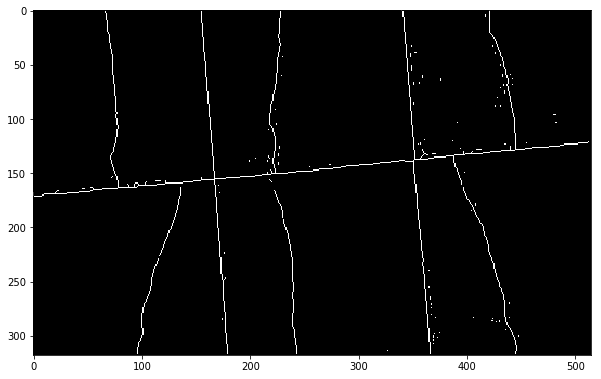

Imagem esqueletizada rotacionada


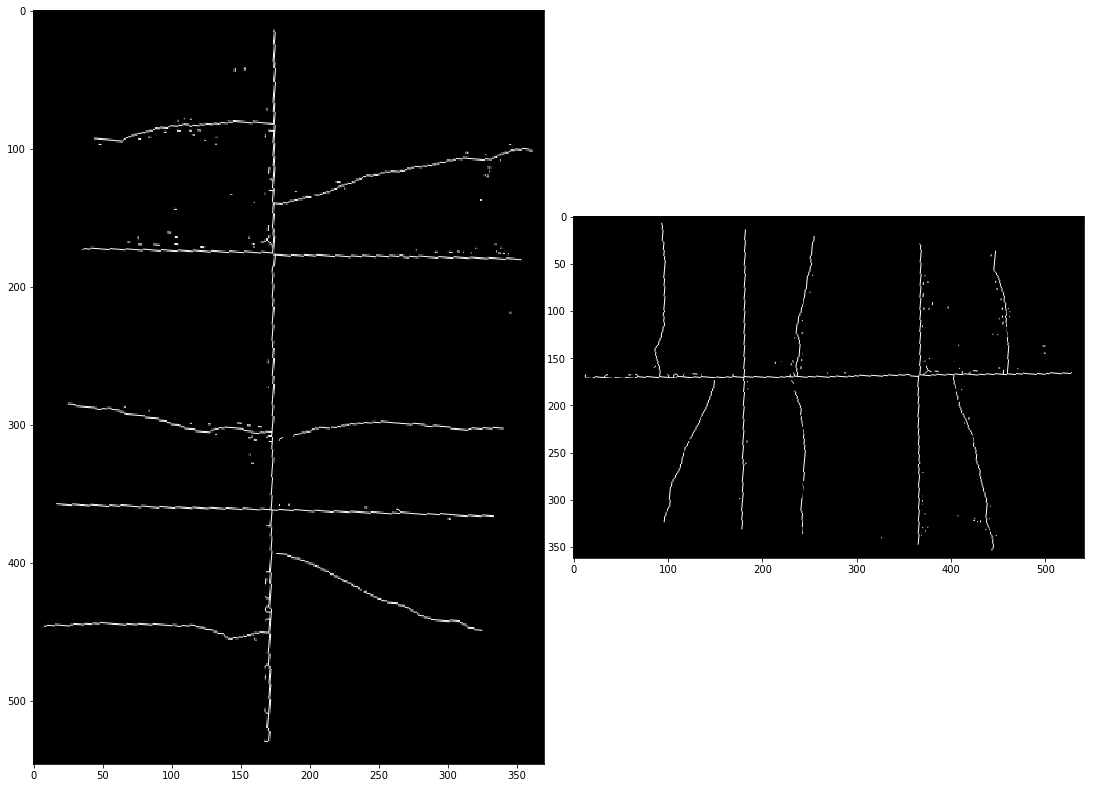

Aplicação do filtro


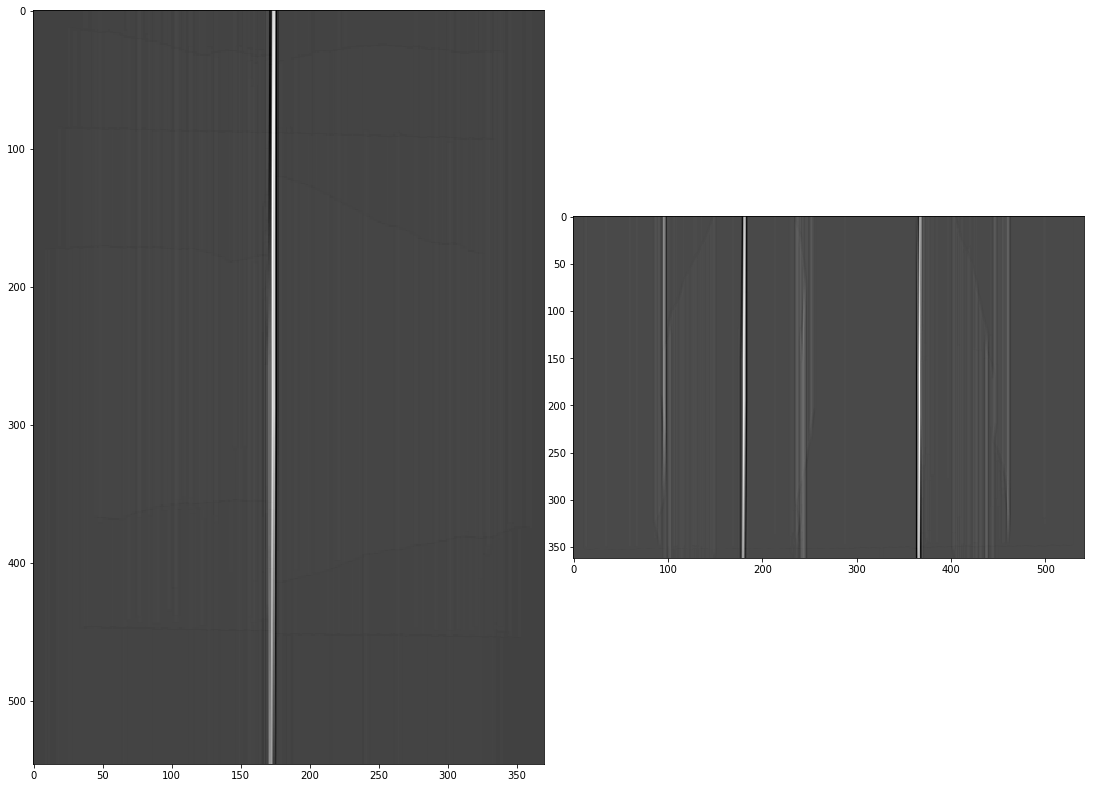

Imagem filtrada rotacionada a posição original


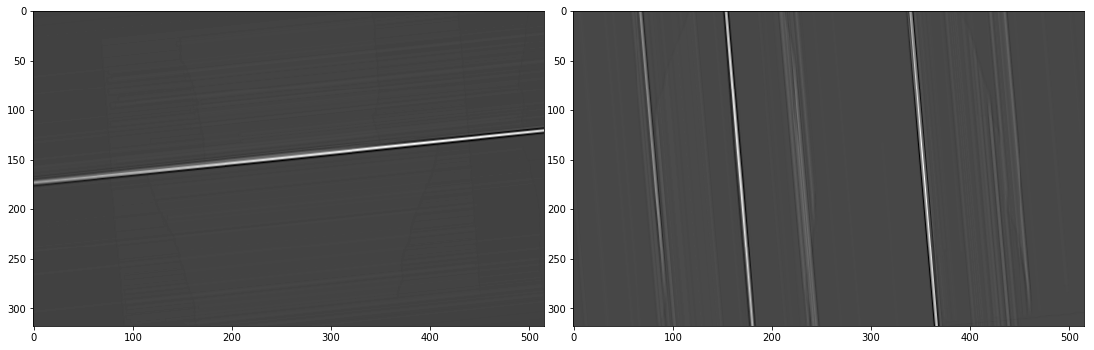

In [ ]:
print("Imagem esqueletizada")
plt.imshow(pimg)
plt.show()
rot_pimg1 = skimage.transform.rotate(pimg, a1-90, resize=True)
rot_pimg2 = skimage.transform.rotate(pimg, a2-90, resize=True)
print("Imagem esqueletizada rotacionada")
plot_img_grid([[rot_pimg1, rot_pimg2]])
plt.show()
width = 3
kernel1 = np.pad(np.ones([rot_pimg1.shape[0], width]), 1, mode='constant', constant_values=-1)
kernel2 = np.pad(np.ones([rot_pimg2.shape[0], width]), 1, mode='constant', constant_values=-1)
corr1 = sp.ndimage.correlate(rot_pimg1, kernel1, mode='constant')
corr2 = sp.ndimage.correlate(rot_pimg2, kernel2, mode='constant')
print("Aplicação do filtro")
plot_img_grid([[corr1, corr2]])
plt.show()
print("Imagem filtrada rotacionada a posição original")
corr_rot1 = utils.cut(skimage.transform.rotate(corr1, 90-a1, resize=True), pimg.shape)
corr_rot2 = utils.cut(skimage.transform.rotate(corr2, 90-a2, resize=True), pimg.shape)
plot_img_grid([[corr_rot1, corr_rot2]])
plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 1080x1080 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f63bf627da0>,
       dtype=object))

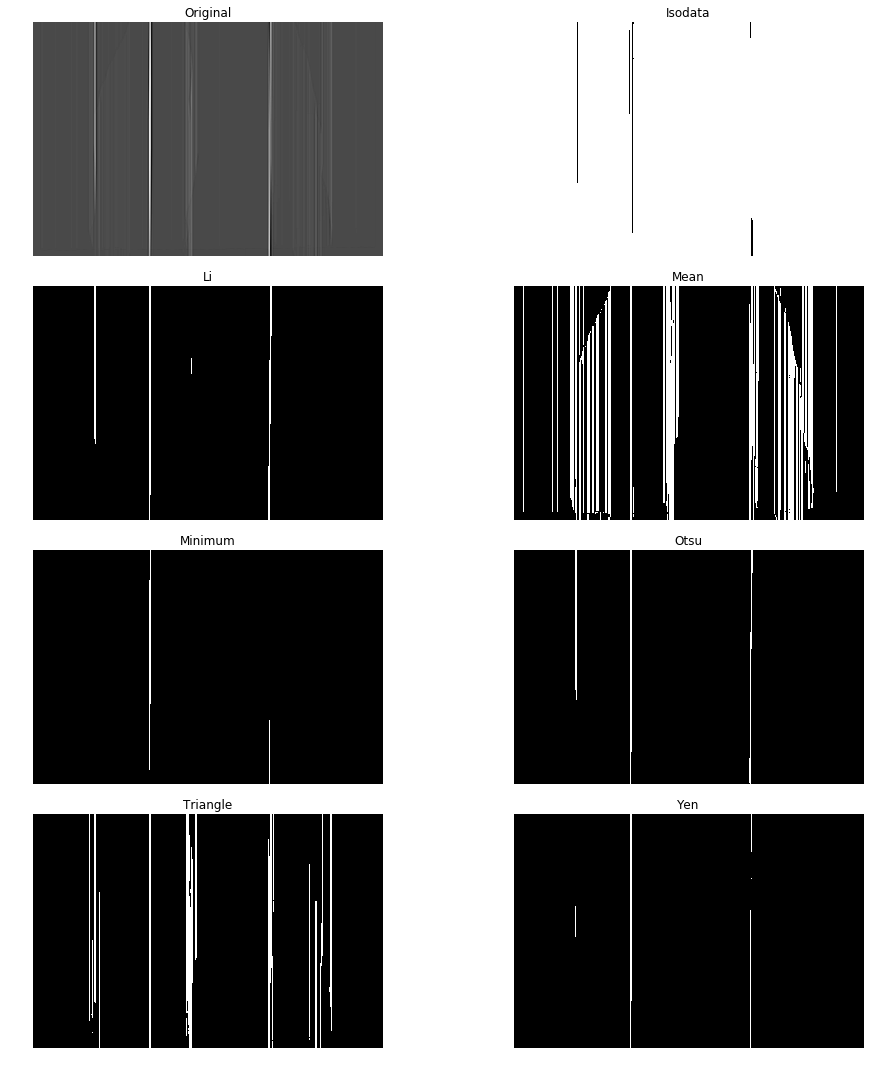

In [ ]:
skimage.filters.try_all_threshold(corr, figsize=(15,15))

# Mascara a partir da imagem filtrada
Em seguida é possível binarizar a imagem filtrada para obter uma mascara para remoção dos rejuntes

Imagem filtrada binarizada


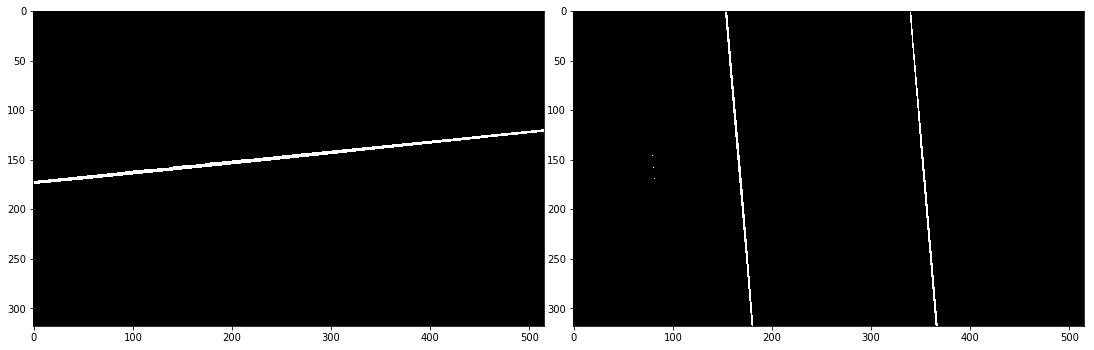

Imagem filtrada binarizada dilatada


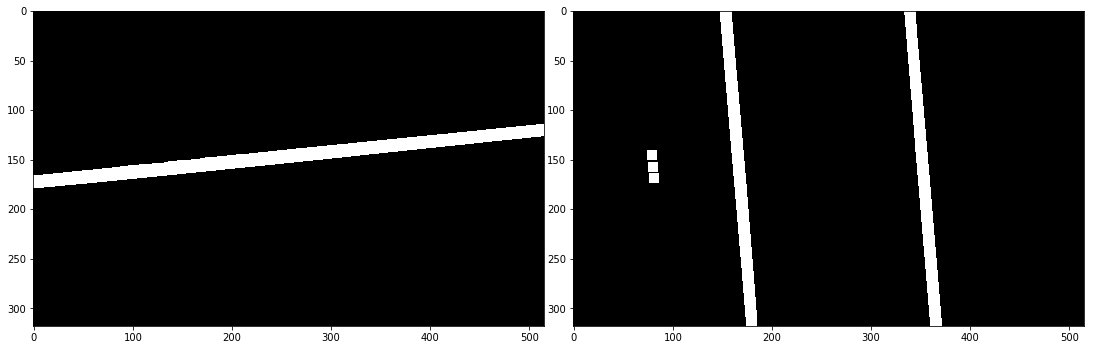

Mascara


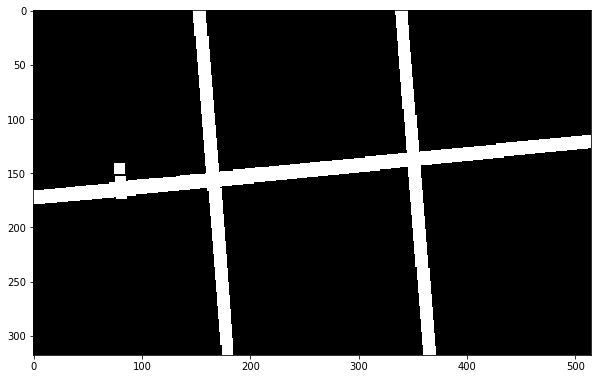

In [ ]:
binary1 = np.where(corr_rot1 > skimage.filters.threshold_yen(corr1), 1, 0)
binary2 = np.where(corr_rot2 > skimage.filters.threshold_yen(corr2), 1, 0)
print('Imagem filtrada binarizada')
plot_img_grid([[binary1, binary2]])
plt.show()
print('Imagem filtrada binarizada dilatada')
selem = np.ones((10,10))
binary_dilated1 = skimage.morphology.dilation(binary1, selem=selem)
binary_dilated2 = skimage.morphology.dilation(binary2, selem=selem)
plot_img_grid([[binary_dilated1, binary_dilated2]])
plt.show()
mask = np.logical_or(binary_dilated1, binary_dilated2)
print('Mascara')
plt.imshow(mask)
plt.show()

# Aplicação da mascara
Agora que temos a mascara é só aplicar na imagem esqueletizada para obter a imagem só com rachaduras

Original => Rachaduras


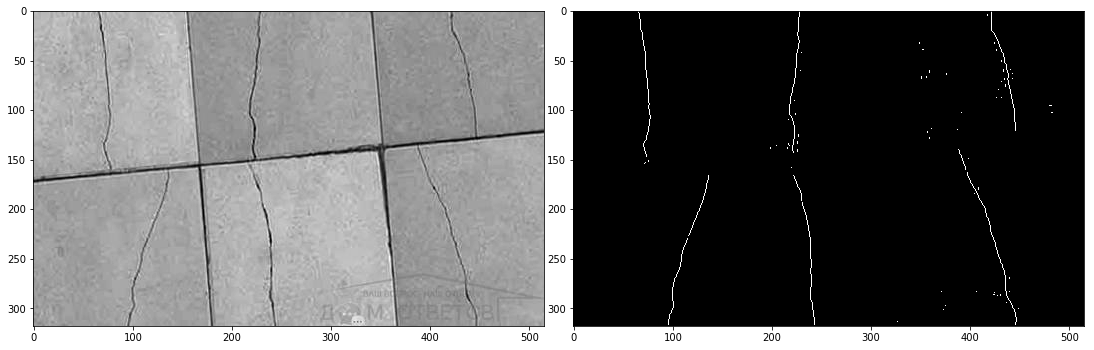

In [ ]:
print('Original => Rachaduras')
rachaduras = (1 - mask)*pimg
plot_img_grid([[img, rachaduras]])
plt.show()

In [ ]:
ones = np.argwhere(binary)[314].flatten()
pos1, pos2 = ones[[0,1]]
pos1, pos2
ones

array([180, 180])

In [ ]:
def aux_plp(binary_img):
    frequencies = []
    phases = []
    height, width = binary_img.shape
    for i in range(height):
        ones = np.argwhere(binary_img[i]).flatten()
        if len(ones) == 1:
            pos = ones[0]
            phase = pos
            period = np.max([pos, width-pos])
        elif len(ones) > 1:
            pos1, pos2 = ones[[0,1]]
            period = pos2-pos1
            phase = pos1
        else:
            continue
        frequencies.append(1/period)
        phases.append(phase)
    return np.mean(frequencies), np.mean(phases)

def periodic_line_parameters(img, angles):
    parameters = []
    for angle in angles:
        rot_img = skimage.transform.rotate(img, angle-90, resize=True)
        width = 3
        kernel = np.pad(np.ones([rot_img.shape[0], width]), width//2, mode='constant', constant_values=-1)
        corr = sp.ndimage.correlate(rot_img, kernel, mode='constant')
        binary = skimage.morphology.skeletonize(np.where(corr > skimage.filters.threshold_minimum(corr), 1, 0))
        parameters.append(aux_plp(binary))
    return parameters

In [ ]:
periodic_line_parameters(pimg, [a1,a2])

[(0.005076465058218435, 173.01246882793018),
 (0.004892084622274588, 191.37292817679557)]

In [ ]:
def attempt1(img):
    threshold = filters.threshold_otsu(img)
    binary = np.where(img > threshold, 255, 0)
    dilated = segmentation.boundaries.dilation(binary)
    eroded = segmentation.boundaries.erosion(dilated)
    result = eroded - binary
    return result

In [ ]:
def try_all_images(detector):
    for i in range(utils.num_images()):
        print(i)
        image = utils.load_image(i)
        mask = detector(image)
        plt.imshow(utils.highlight(image, mask))
        plt.show()